Install Library and Dependency

In [4]:
!pip install numpy pandas matplotlib scikit-learn tensorflow keras opencv-python



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


Load the data from the correct path


In [2]:
# Define the path to  dataset
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt




Define Watershed Feature Extraction Function

In [4]:
def apply_watershed(image):
    # Step 1: Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 2: Convert image to grayscale
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    
    # Step 3: Apply adaptive thresholding for more refined segmentation
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Step 4: Use morphology to remove noise and smoothen boundaries
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Step 5: Find sure background by dilating the image (for more solid areas)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Step 6: Use distance transform to find sure foreground
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    
    # Step 7: Perform additional morphological closing to reduce small segments
    sure_fg = np.uint8(sure_fg)
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # Step 8: Find unknown region by subtracting foreground from background
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Step 9: Label markers
    _, markers = cv2.connectedComponents(sure_fg)
    
    # Step 10: Add 1 to all labels so that the background is not 0
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Step 11: Apply the Watershed algorithm
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark boundaries with red
    
    return image


Define Datapath (load data) + Appply with watershed Alg.

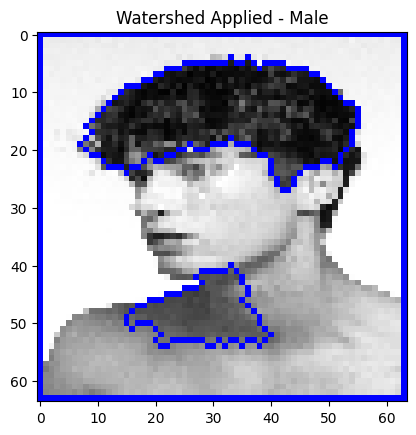

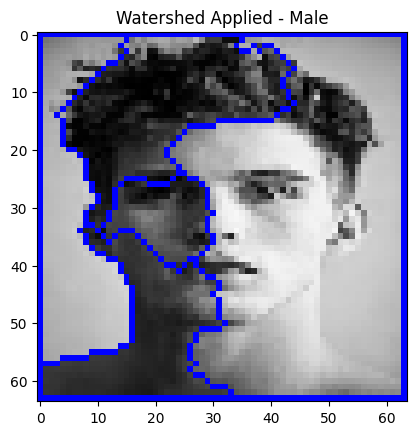

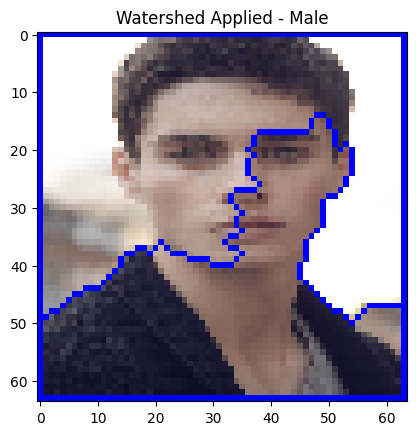

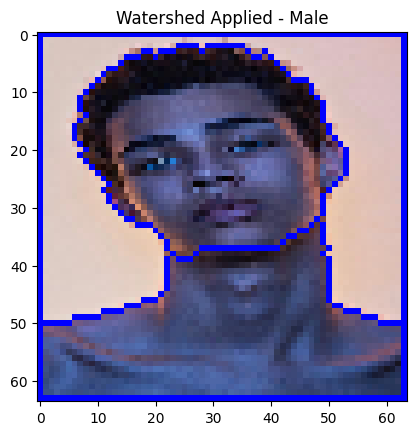

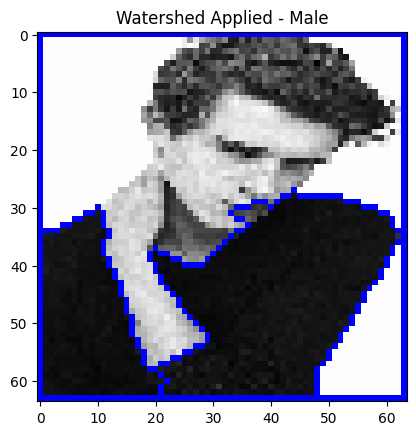

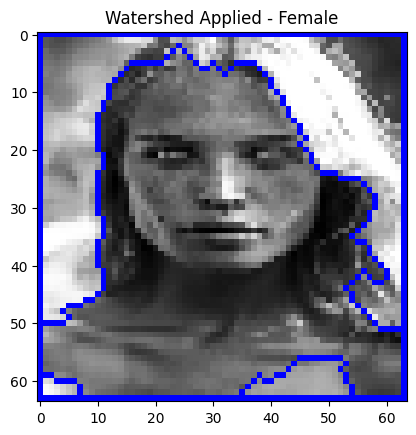

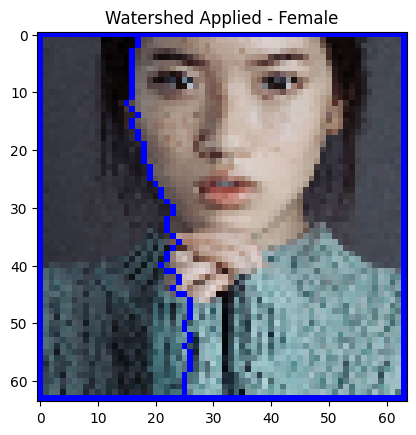

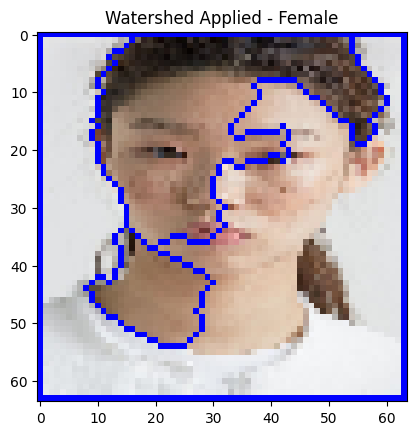

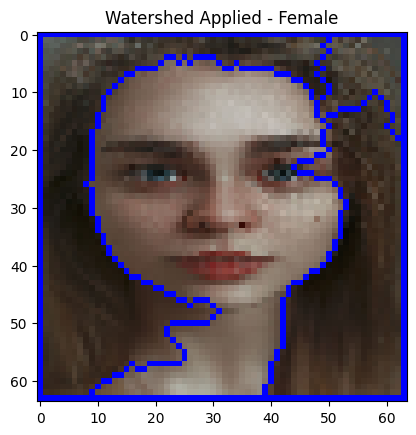

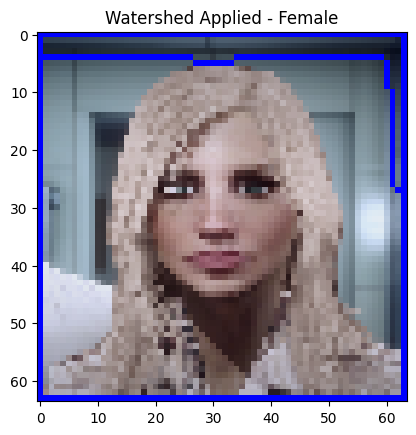

Loaded 5418 images with watershed features.


In [5]:
# Define the path to dataset
dataset_path = '/Users/mmatttrp/Desktop/test/Male and_Female_face_dataset'  

images = []
labels = []
num_images_to_display = 5  # Number of watershed outputs to display

# Loop through 'Male_Faces' and 'Female_Faces' directories
for label_folder in ['Male_Faces', 'Female_Faces']:
    folder_path = os.path.join(dataset_path, label_folder)
    label = 0 if label_folder == 'Male_Faces' else 1  # 0 for Male, 1 for Female
    for i, image_file in enumerate(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (64, 64))  # Resize images to 64x64
            
            # Apply the Watershed algorithm for feature extraction
            watershed_image = apply_watershed(image)
            
            images.append(watershed_image)
            labels.append(label)
            
            # Display some images with watershed applied
            if i < num_images_to_display:
                plt.imshow(cv2.cvtColor(watershed_image, cv2.COLOR_BGR2RGB))
                plt.title(f"Watershed Applied - {'Male' if label == 0 else 'Female'}")
                plt.show()

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize images to a 0-1 range
images = images / 255.0

print(f"Loaded {len(images)} images with watershed features.")


Split Dataset with ratio 80/20

In [6]:
# Split the data into training and testing sets with an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


Define ANN Model
Why Convolutional Neural Network (CNN)

-Preserves Spatial Relationships: CNNs can capture the spatial structure of images, which is essential when working with images like faces.

-Feature Learning: CNNs automatically learn important features (e.g., edges, shapes) from the images through convolution, which is something an MLP cannot do as effectively.


Convolutional Layers (Conv2D): These layers detect and extract features like edges, textures, and patterns from the image. CNNs are better for image data than standard ANNs (like MLPs) because they preserve spatial relationships. Your code uses three convolutional layers with increasing filters (32, 64, 128) to capture more complex features.

Pooling Layers (MaxPooling2D): These layers reduce the size of the feature maps to minimize computation and reduce overfitting by downsampling the input.

Flatten Layer: Converts the 2D feature maps into a 1D vector, so they can be passed to fully connected (Dense) layers.

Fully Connected Layers (Dense): After feature extraction, a Dense layer with 128 neurons (using ReLU) is used to learn from the extracted features. The final Dense layer has 2 neurons with softmax activation, outputting probabilities for the two classes (male or female).

In [7]:
# Step 1: Define the ANN (Multilayer Perceptron, but in this case it's a CNN)
model = Sequential()  # Initialize a sequential model where layers are stacked in order.

# Add convolutional layers to extract features from the image
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# Conv2D applies 32 filters of size 3x3 to the input image to extract features like edges.
# The 'relu' activation introduces non-linearity, and the input shape specifies 64x64 images with 3 color channels (RGB).

model.add(MaxPooling2D(pool_size=(2, 2)))
# MaxPooling reduces the spatial size of the feature maps by a factor of 2x2, which helps in downsampling and reducing computation.

model.add(Conv2D(64, (3, 3), activation='relu'))
# Another convolutional layer, now with 64 filters of size 3x3, to learn more complex features from the previous layer's output.

model.add(MaxPooling2D(pool_size=(2, 2)))
# Another MaxPooling layer to reduce the spatial dimensions after the second convolution.

model.add(Conv2D(128, (3, 3), activation='relu'))
# A third convolutional layer with 128 filters to extract even more complex features (like shapes, textures).

model.add(MaxPooling2D(pool_size=(2, 2)))
# Final MaxPooling layer to downsample the feature maps from the previous convolution.

# Flatten the output and add fully connected layers
model.add(Flatten())
# Flatten converts the 2D feature maps into a 1D vector, so they can be fed into fully connected (Dense) layers.
# Example: If you have 7x7x128 feature maps, Flatten will convert them into a single 1D vector of size 7*7*128 = 6272.

model.add(Dense(128, activation='relu'))
# Fully connected (Dense) layer with 128 neurons to learn from the flattened data. The 'relu' activation introduces non-linearity.

model.add(Dense(2, activation='softmax'))  # Output layer for binary classification
# Output layer with 2 neurons (since it's a binary classification task, e.g., male/female).
# 'softmax' activation is used to output probabilities for the two classes (e.g., probability of male or female).


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train the model

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)



Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6120 - loss: 0.6483 - val_accuracy: 0.7629 - val_loss: 0.4718
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8450 - loss: 0.3564 - val_accuracy: 0.9031 - val_loss: 0.2476
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9255 - loss: 0.1944 - val_accuracy: 0.9345 - val_loss: 0.1794
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9635 - loss: 0.1011 - val_accuracy: 0.9760 - val_loss: 0.0947
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9854 - loss: 0.0508 - val_accuracy: 0.9852 - val_loss: 0.0495
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9932 - loss: 0.0203 - val_accuracy: 0.9917 - val_loss: 0.0421
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9980 - loss: 0.0095 - val_accuracy: 0.9899 - val_loss: 0.0397
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9980 - loss: 0.0076 - val_accu

In [14]:
%pip install pydot
%pip install graphviz



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Structure flow

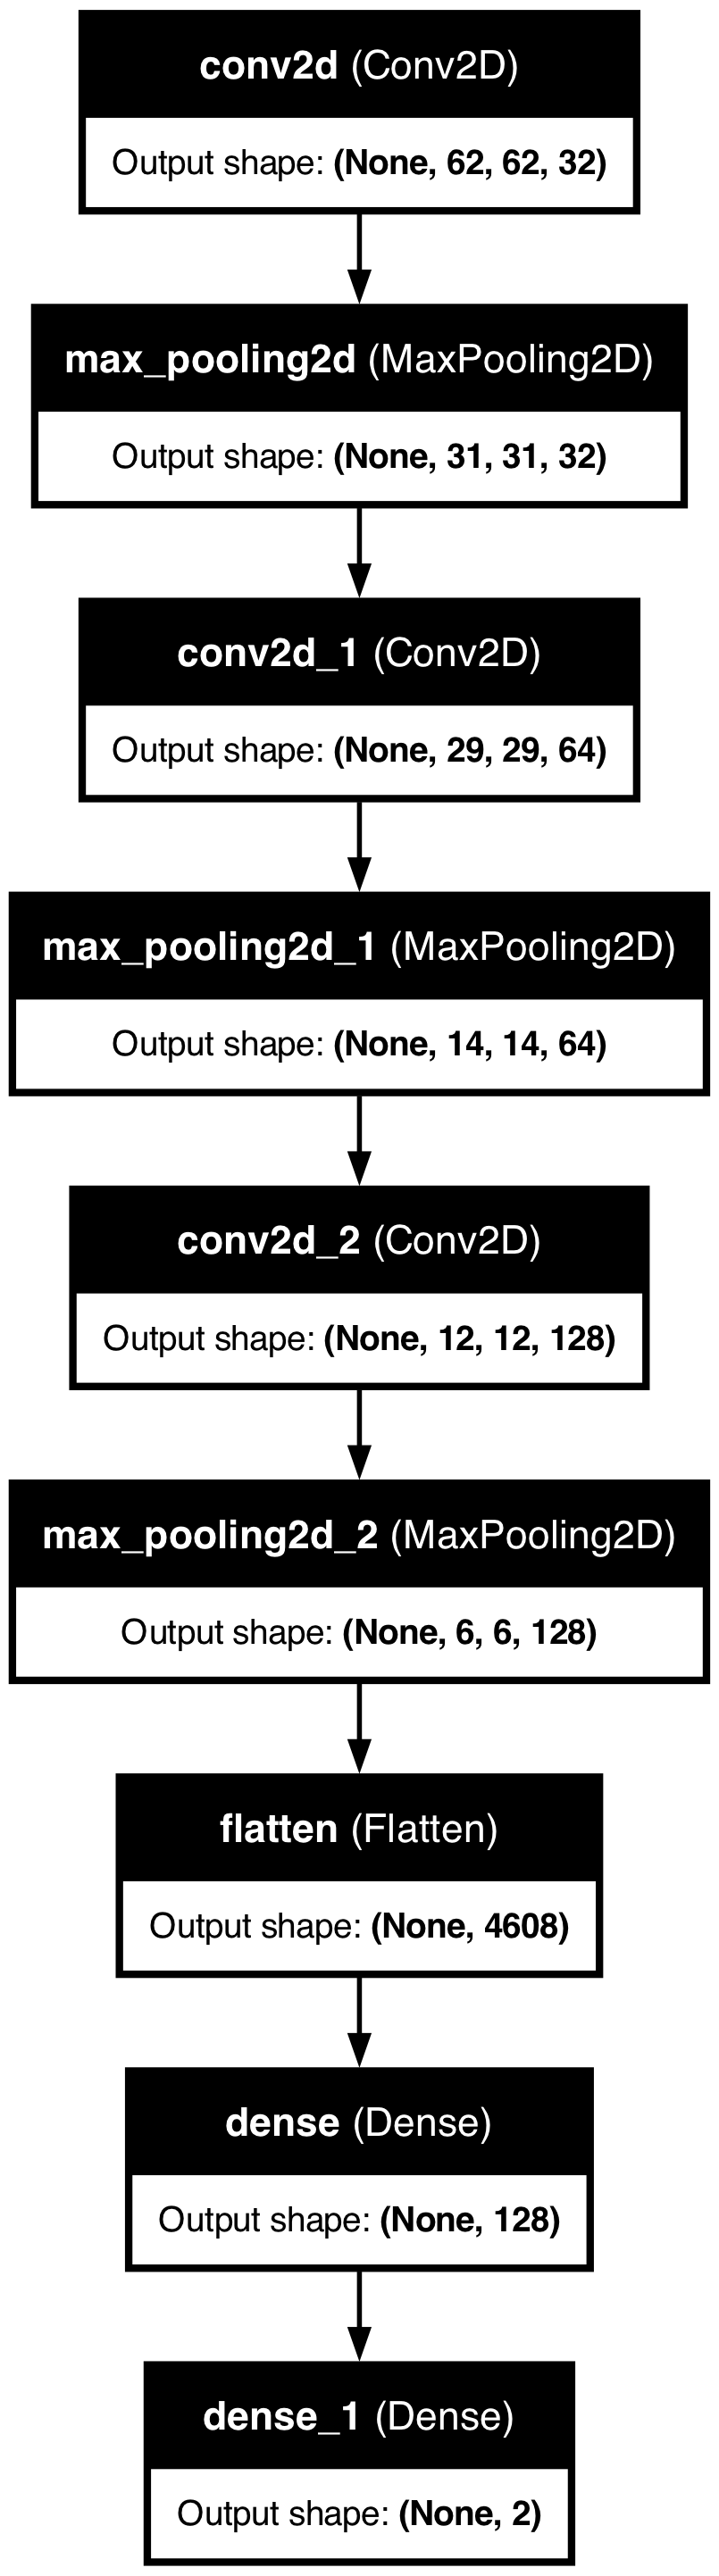

In [14]:
from tensorflow.keras.utils import plot_model

# Visualize and save the model structure as a PNG file
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)


Plot the Loss and Accuracy

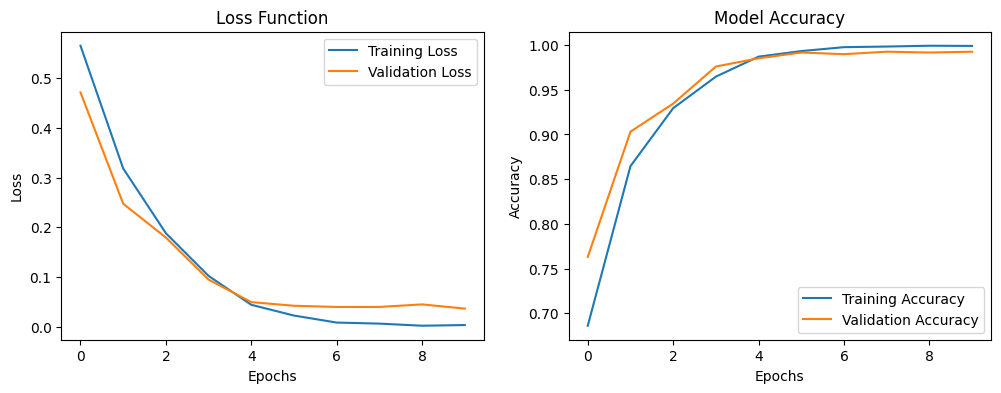

In [9]:
# Step 4: Plotting the loss function and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Evaluate the Model

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9948 - loss: 0.0335
Test Accuracy: 99.26%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


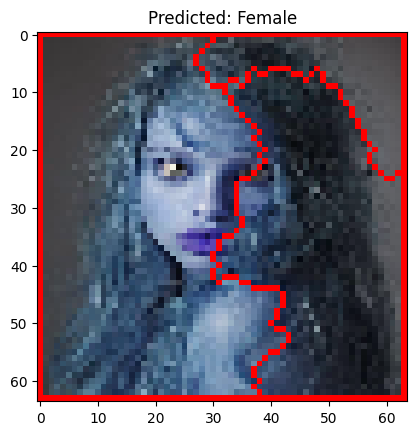

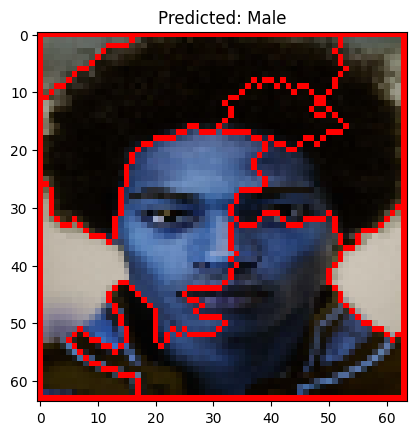

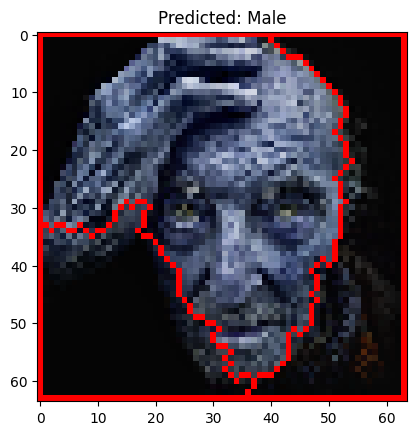

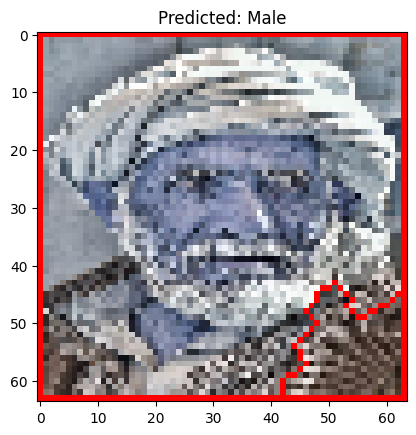

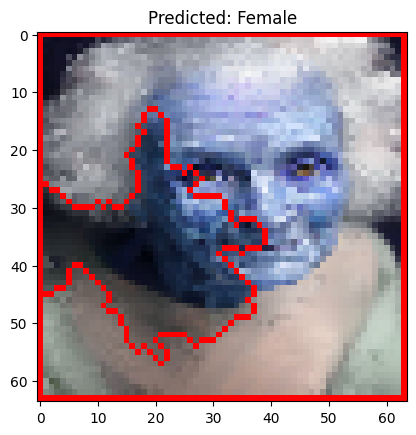

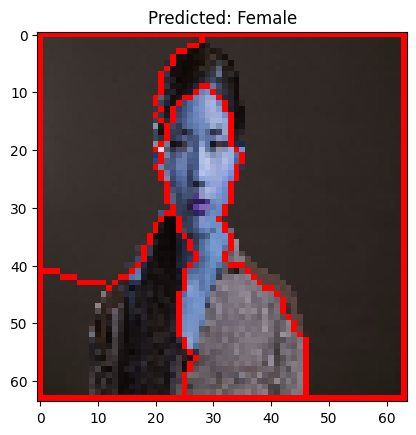

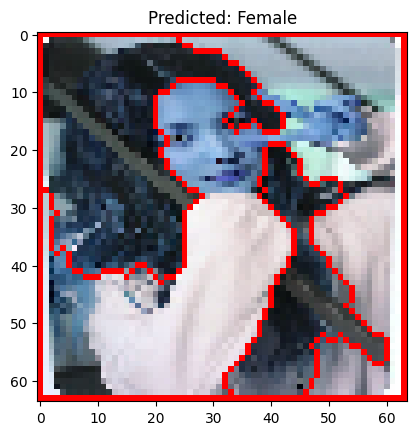

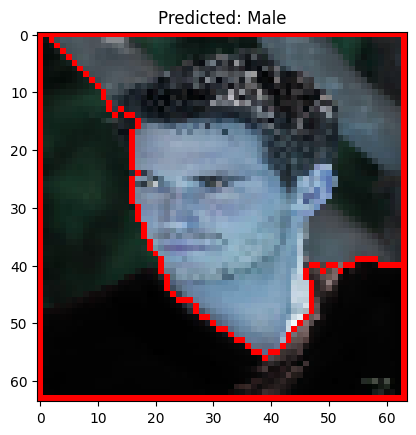

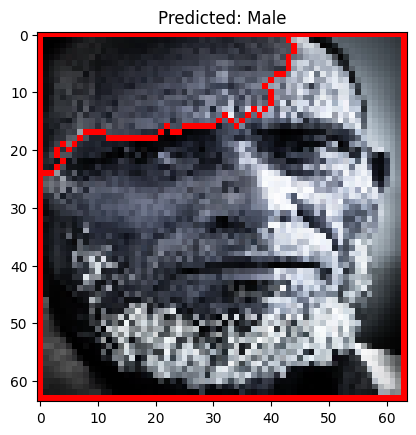

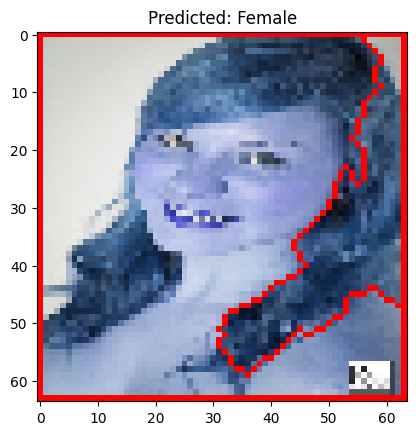

In [10]:
# Step 5: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Example predictions on 10 test images
predictions = model.predict(X_test[:10])

# Display 10 example test images with predicted labels
for i in range(10):  # Change the range from 5 to 10
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {'Male' if np.argmax(predictions[i]) == 0 else 'Female'}")
    plt.show()


Check other image. Does it's Male or Female

In [11]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('gender_classifier_model.h5')


(None, 12288)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


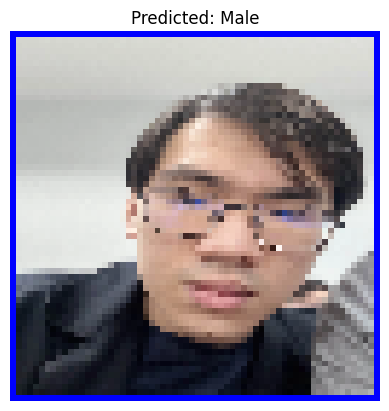

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Print the model input shape to verify the expected shape
print(model.input_shape)

# The function to apply watershed
def apply_watershed(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)  # Apply histogram equalization for better contrast
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 0] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark the boundaries in red
    return image

# The function to preprocess the image, apply watershed, and predict gender
def preprocess_and_predict(image_path, model):
    # Step 1: Load and preprocess the image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (64, 64))  # Resize to 64x64 as required by the model

    # Step 2: Apply the watershed algorithm for feature extraction
    watershed_img = apply_watershed(img_resized)
    
    # Step 3: Normalize the image
    img_normalized = watershed_img / 255.0  # Normalize the image

    # Step 4: Flatten the image if the model was trained on flattened images
    img_flattened = img_normalized.reshape(1, -1)  # Flatten the image (1D array)

    # Step 5: Make a prediction
    prediction = model.predict(img_flattened)

    # Step 6: Display the image and prediction
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))  # Show original image
    plt.title(f"Predicted: {'Male' if prediction < 0.5 else 'Female'}")
    plt.axis('off')  # Hide the axis
    plt.show()

# Example usage: 
# Upload an image file and specify the path
image_path = '/Users/mmatttrp/Desktop/test/IMG_0923.webp'  # Replace with the actual path to the image

# Call the function to preprocess, apply watershed, and predict the uploaded image
preprocess_and_predict(image_path, model)
